In [4]:
import rpy2
import rpy2.robjects.lib.ggplot2 as ggplot2
import rpy2.robjects as ro
from rpy2.robjects.packages import importr
base = importr('base')

# the base of rpy2 plotting is matplotlib, thus we need to declare
# it inline in order to see the plots in the notebook
%matplotlib inline

# we need to activate the automatic conversion for pandas
from rpy2.robjects import pandas2ri
pandas2ri.activate()

# load the needed extension for the %%R cell magic
%load_ext rpy2.ipython

import numpy as np
import pandas as pd
import glob
import toml

%config IPCompleter.greedy=True

import matplotlib.pylab as plt
plt.rcParams['figure.dpi'] = 200

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [9]:
rootdir = "/Users/akshay/research/burrito"
outdirs = ["tput-bbbd4b3"]

In [11]:
def read_toml(cfg):
    return toml.load(cfg)['exp']

def merge_tomls(cfgs):
    merged_cfg = {}
    for cfg in cfgs:
        for key in cfg:
            if key in merged_cfg:
                if type(cfg[key]) != type(merged_cfg[key]):
                    raise Exception(f"mismatched config types: {cfg[key]} vs {merged_cfg[key]}")
                if type(cfg[key]) == int and merged_cfg[key] != cfg[key]:
                    raise Exception(f"int-valued configs must match: {cfg[key]} vs {merged_cfg[key]}")
                if type(cfg[key]) == list:
                    merged_cfg[key] = list(set(cfg[key]).union(set(merged_cfg[key])))
            else:
                merged_cfg[key] = cfg[key]
    return merged_cfg

tomls = {}
for outdir in outdirs:
    od = f"{rootdir}/{outdir}"
    cfgs = glob.glob(f"{od}/*.toml")
    tomls[outdir] = merge_tomls([read_toml(t) for t in cfgs])

tomls

{'tput-bbbd4b3': {'num_clients': [10],
  'file_size': [5000000000],
  'packet_size': [64, 128, 256, 512, 1024, 1460],
  'datapath': ['dpdkinline', 'shenangort'],
  'iters': 5,
  'bertha': ['raw',
   'full:0',
   'full:1',
   'full:2',
   'full:3',
   'full:4',
   'full:5']}}

In [13]:
# note: this aggregates requestclients together

def read_exp(outdir, dp, st, nc, fs, ps, num_iters):
    exp = []
    for i in range(num_iters):
        fn_wildcard = f"{rootdir}/{outdir}/{dp}_{st}-num_clients={nc}-file_size={fs}-packet_size={ps}-{i}-tbench_client-*.data"
        fn = glob.glob(fn_wildcard)
        if len(fn) != 1:
            raise Exception(f"unexpected number of data files: {fn}")
            
        try:
            df_iter = pd.read_csv(fn[0])
            df_iter["iter"] = i
            df_iter["Commit"] = outdir
            df_iter["Datapath"] = dp
            df_iter["StackType"] = st
            del df_iter["download_size"]
            del df_iter["elapsed_us"]
            del df_iter['tot_bytes']
            exp.append(df_iter)
        except Exception as e:
            pass
    if len(exp) > 0:
        return pd.concat(exp)
    else:
        return pd.DataFrame()

exps = []
for outdir in outdirs:
    cfg = tomls[outdir]
    datapaths = cfg['datapath']
    stack_types = cfg['bertha']
    num_clients = cfg['num_clients']
    file_sizes = cfg['file_size']
    packet_sizes = cfg['packet_size']
    num_iters = cfg['iters']
    
    for dp in datapaths:
        for st in stack_types:
            for nc in num_clients:
                for fs in file_sizes:
                    for ps in packet_sizes:
                        df = read_exp(outdir, dp, st, nc, fs, ps, num_iters)
                        exps.append(df)
                    
exps = pd.concat(exps)

exps = exps.groupby(["Commit", "Datapath", "StackType", "num_clients", "packet_size"]).quantile([0.25, 0.5, 0.75])
exps = exps.unstack()
exps.columns = [f"{s}_{t}" for s,t in exps.columns.values]
exps.columns = exps.columns.to_flat_index()
exps = exps.reset_index()
exps

,Commit,Datapath,StackType,num_clients,packet_size,tot_pkts_0.25,tot_pkts_0.5,tot_pkts_0.75,rate_bps_0.25,rate_bps_0.5,rate_bps_0.75,rate_pps_0.25,rate_pps_0.5,rate_pps_0.75,iter_0.25,iter_0.5,iter_0.75
0,tput-bbbd4b3,dpdkinline,full:0,10,64,780650420.0,780651612.0,780655265.0,8.234320e+09,8.251007e+09,8.279521e+09,1.608266e+07,1.611525e+07,1.617094e+07,1.0,2.0,3.0
1,tput-bbbd4b3,dpdkinline,full:0,10,128,390349553.0,390349930.0,390359248.0,1.340897e+10,1.342095e+10,1.342357e+10,1.309470e+07,1.310640e+07,1.310896e+07,1.0,2.0,3.0
2,tput-bbbd4b3,dpdkinline,full:0,10,256,195233654.0,195234843.0,195235033.0,1.916187e+10,1.922225e+10,1.923240e+10,9.356383e+06,9.385867e+06,9.390819e+06,1.0,2.0,3.0
3,tput-bbbd4b3,dpdkinline,full:0,10,512,97649872.0,97649948.0,97650124.0,2.214195e+10,2.214203e+10,2.214219e+10,5.405750e+06,5.405771e+06,5.405809e+06,1.0,2.0,3.0
4,tput-bbbd4b3,dpdkinline,full:0,10,1024,48828140.0,48828140.0,48828140.0,2.348657e+10,2.348658e+10,2.348662e+10,2.867013e+06,2.867015e+06,2.867020e+06,1.0,2.0,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
79,tput-bbbd4b3,shenangort,raw,10,128,390553144.0,390555562.0,390558140.0,5.752163e+09,5.771581e+09,5.800842e+09,5.617347e+06,5.636309e+06,5.664885e+06,1.0,2.0,3.0
80,tput-bbbd4b3,shenangort,raw,10,256,195231784.0,195237447.0,195240970.0,1.127969e+10,1.136426e+10,1.142332e+10,5.507662e+06,5.548956e+06,5.577792e+06,1.0,2.0,3.0
81,tput-bbbd4b3,shenangort,raw,10,512,97589628.0,97598125.0,97602379.0,2.129580e+10,2.134694e+10,2.144014e+10,5.199169e+06,5.211656e+06,5.234411e+06,1.0,2.0,3.0
82,tput-bbbd4b3,shenangort,raw,10,1024,48814366.0,48817845.0,48820000.0,4.395215e+09,5.633556e+09,9.754021e+09,5.365254e+05,6.876901e+05,1.190677e+06,1.0,2.0,3.0


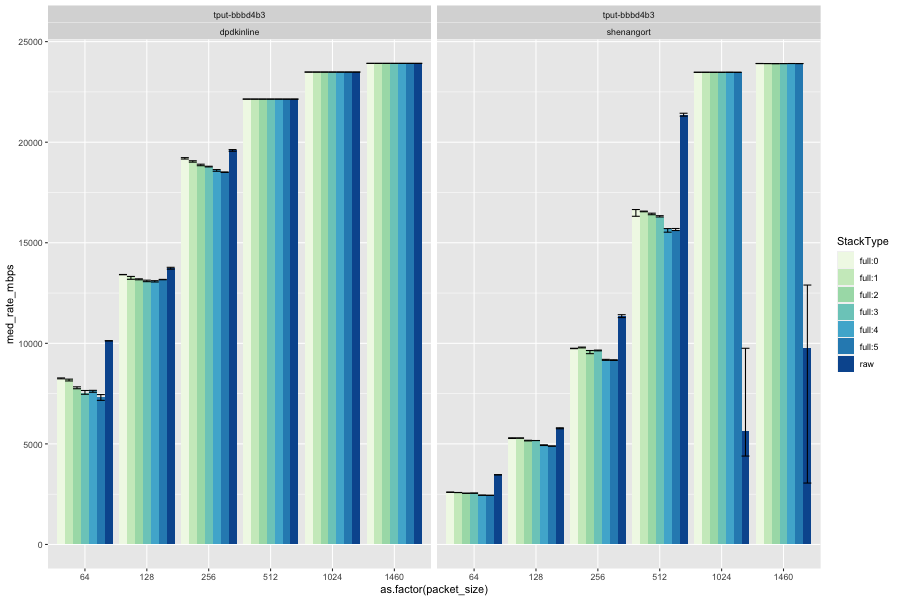

In [14]:
%%R -i exps -w 900 -h 600

# Mbit/s graph (throughput)

library(ggplot2)

exps$med_rate_mbps <- exps$rate_bps_0.5 / 1e6
exps$low_rate_mbps <- exps$rate_bps_0.25 / 1e6
exps$hih_rate_mbps <- exps$rate_bps_0.75 / 1e6
ggplot(exps, aes(x=as.factor(packet_size), y=med_rate_mbps, fill=StackType)) +
  geom_col(position="dodge") +
  geom_errorbar(aes(ymin=low_rate_mbps, ymax=hih_rate_mbps), position="dodge") +
  scale_fill_brewer(type="seq", palette=4) +
  facet_wrap(Commit ~ Datapath)

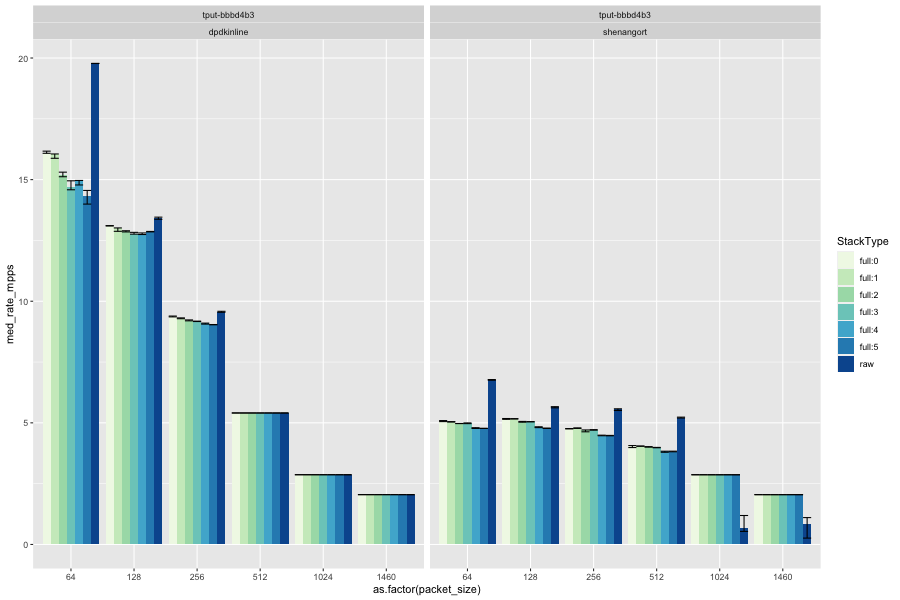

In [16]:
%%R -i exps -w 900 -h 600

# Mpps graph (packets)

library(ggplot2)

exps$med_rate_mpps <- exps$rate_pps_0.5 / 1e6
exps$low_rate_mpps <- exps$rate_pps_0.25 / 1e6
exps$hih_rate_mpps <- exps$rate_pps_0.75 / 1e6
ggplot(exps, aes(x=as.factor(packet_size), y=med_rate_mpps, fill=StackType)) +
  geom_col(position="dodge") +
  geom_errorbar(aes(ymin=low_rate_mpps, ymax=hih_rate_mpps), position="dodge") +
  scale_fill_brewer(type="seq", palette=4) +
  facet_wrap(Commit ~ Datapath) 

In [27]:
def do_norm(x):
    return pd.DataFrame({
        "Commit": x['Commit'],
        "Datapath": x["Datapath"],
        "StackType": x["StackType"],
        "num_clients": x["num_clients"],
        "packet_size": x["packet_size"],
        "norm_bps_p25": x["rate_bps_0.25"] / x[x["StackType"] == "raw"]["rate_bps_0.25"].iloc[0],
        "norm_bps_p5": x["rate_bps_0.5"] / x[x["StackType"] == "raw"]["rate_bps_0.5"].iloc[0],
        "norm_bps_p75": x["rate_bps_0.75"] / x[x["StackType"] == "raw"]["rate_bps_0.75"].iloc[0],
        "norm_pps_p25": x["rate_pps_0.25"] / x[x["StackType"] == "raw"]["rate_pps_0.25"].iloc[0],
        "norm_pps_p5": x["rate_pps_0.5"] / x[x["StackType"] == "raw"]["rate_pps_0.5"].iloc[0],
        "norm_pps_p75": x["rate_pps_0.75"] / x[x["StackType"] == "raw"]["rate_pps_0.75"].iloc[0],
    })

norm = exps.groupby(
  ["Commit", "Datapath", "num_clients", "packet_size"], group_keys=False,
).apply(do_norm)
norm = norm.reset_index(drop=True)
norm

,Commit,Datapath,StackType,num_clients,packet_size,norm_bps_p25,norm_bps_p5,norm_bps_p75,norm_pps_p25,norm_pps_p5,norm_pps_p75
0,tput-bbbd4b3,dpdkinline,full:0,10,64,0.813321,0.814856,0.817546,0.813321,0.814856,0.817546
1,tput-bbbd4b3,dpdkinline,full:0,10,128,0.979486,0.975259,0.974128,0.979486,0.975259,0.974128
2,tput-bbbd4b3,dpdkinline,full:0,10,256,0.980105,0.980257,0.979582,0.980105,0.980257,0.979582
3,tput-bbbd4b3,dpdkinline,full:0,10,512,1.000006,1.000006,1.000008,1.000006,1.000006,1.000008
4,tput-bbbd4b3,dpdkinline,full:0,10,1024,1.000007,1.000007,1.000009,1.000007,1.000007,1.000009
...,...,...,...,...,...,...,...,...,...,...,...
79,tput-bbbd4b3,shenangort,raw,10,128,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
80,tput-bbbd4b3,shenangort,raw,10,256,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
81,tput-bbbd4b3,shenangort,raw,10,512,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
82,tput-bbbd4b3,shenangort,raw,10,1024,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


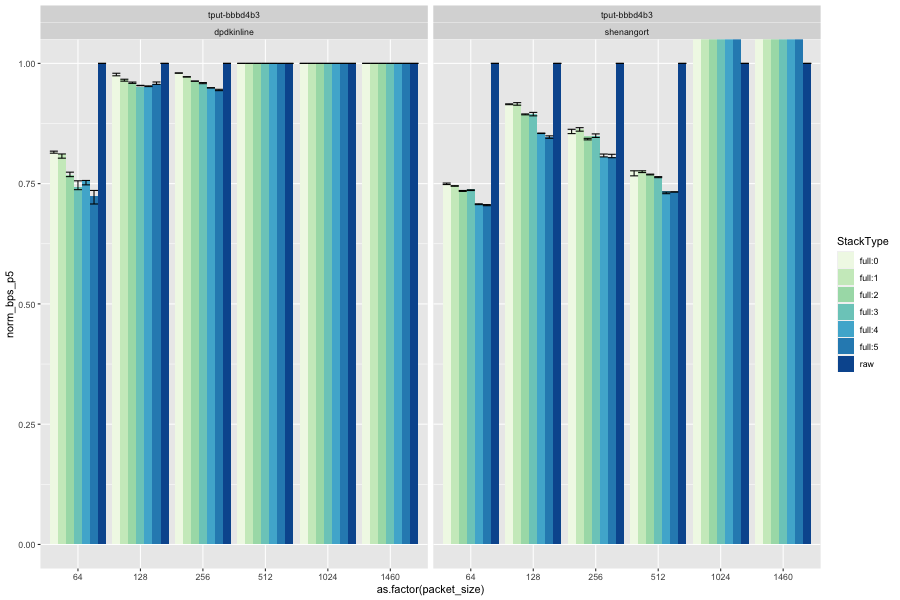

In [31]:
%%R -i norm -w 900 -h 600

# norm Mbit/s graph (throughput)

library(ggplot2)

ggplot(norm, aes(x=as.factor(packet_size), y=norm_bps_p5, fill=StackType)) +
  geom_col(position="dodge") +
  geom_errorbar(aes(ymin=norm_bps_p25, ymax=norm_bps_p75), position="dodge") +
  scale_fill_brewer(type="seq", palette=4) +
  coord_cartesian(ylim=c(0,1)) +
  facet_wrap(Commit ~ Datapath)

In [37]:
norm[(norm["Datapath"] == "dpdkinline") & (norm["packet_size"] == 128)]

,Commit,Datapath,StackType,num_clients,packet_size,norm_bps_p25,norm_bps_p5,norm_bps_p75,norm_pps_p25,norm_pps_p5,norm_pps_p75
1,tput-bbbd4b3,dpdkinline,full:0,10,128,0.979486,0.975259,0.974128,0.979486,0.975259,0.974128
7,tput-bbbd4b3,dpdkinline,full:1,10,128,0.963059,0.968210,0.967065,0.963059,0.968210,0.967065
13,tput-bbbd4b3,dpdkinline,full:2,10,128,0.961135,0.958466,0.958419,0.961135,0.958466,0.958419
19,tput-bbbd4b3,dpdkinline,full:3,10,128,0.954365,0.950486,0.953542,0.954365,0.950486,0.953542
25,tput-bbbd4b3,dpdkinline,full:4,10,128,0.953168,0.950520,0.951717,0.953168,0.950520,0.951717
31,tput-bbbd4b3,dpdkinline,full:5,10,128,0.961324,0.957236,0.956413,0.961324,0.957236,0.956413
37,tput-bbbd4b3,dpdkinline,raw,10,128,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
